# Uncertainty and sensitivity analyses

Using the Sensitivity Analysis Library [SALib](https://salib.readthedocs.io/en/latest/) in Python.

In [1]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# From AeroMetric
from aerometrics.utils.functions import emission_profile_function
from aerometrics.metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from aerometrics.climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from aerometrics.climate_models.lwe_climate_model import species_lwe_climate_model
from aerometrics.climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

# Sensitivity analysis
from SALib.sample import saltelli
from SALib.sample import morris as morris_sampler
from SALib.analyze import sobol, morris
from SALib import ProblemSpec
from scipy.stats import norm

In [2]:
def gwp_rf_function(time_horizon, sensitivity_rf):
    metric = 4.56e14 * sensitivity_rf / time_horizon**0.801
    return metric

def gwp_erf_function(time_horizon, sensitivity_rf, ratio_erf_rf):
    metric = 4.56e14 * sensitivity_rf * ratio_erf_rf / time_horizon**0.801
    return metric

def egwp_function(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf):
    metric = 4.56e14 * sensitivity_rf * ratio_erf_rf * efficacy_erf / time_horizon**0.801
    return metric

def ratr_function(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf):
    metric = 6.25e14 * sensitivity_rf * ratio_erf_rf * efficacy_erf / time_horizon**0.843
    return metric

In [3]:
def climate_metric_parametric(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf):

    gwp_rf = gwp_rf_function(time_horizon, sensitivity_rf)
    gwp_erf = gwp_erf_function(time_horizon, sensitivity_rf, ratio_erf_rf)
    egwp_erf = egwp_function(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf)
    ratr = ratr_function(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf)

    return gwp_rf, gwp_erf, egwp_erf, ratr

In [4]:
# Define problem
sp = ProblemSpec({
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        [2.23e-12, 7.96e-13],
        [0.23, 0.87], 
        [0.12, 0.64]
    ],
    'dists': ['norm', 'unif', 'unif'],
    "outputs": ["gwp_rf", "gwp_erf", "egwp_erf", "ratr"],
})

# Create samples
sp.sample_sobol(2048, calc_second_order=False)

# Create wrapper for function
time_horizon=100
def wrapped_func(X):
    return np.array([climate_metric_parametric(time_horizon, *row) for row in X])

# Run simulations
sp.evaluate(wrapped_func);

# Calculate sobol indices
sp.analyze_sobol(print_to_console=False, calc_second_order=False);

C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


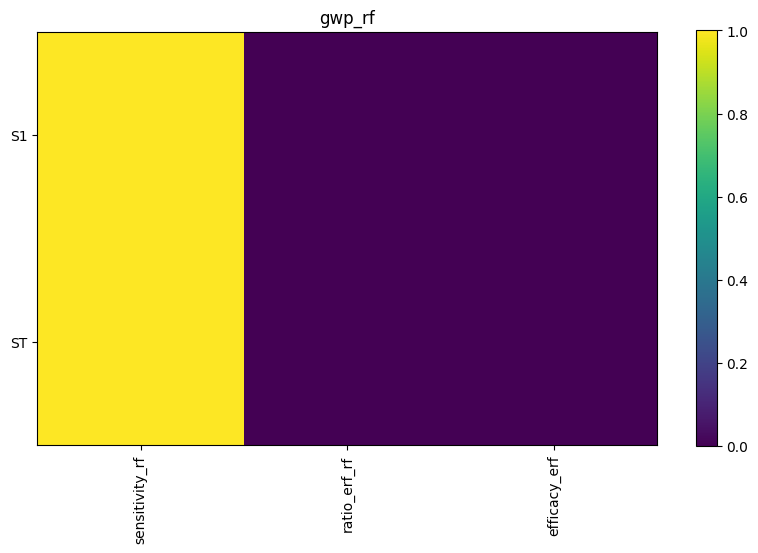

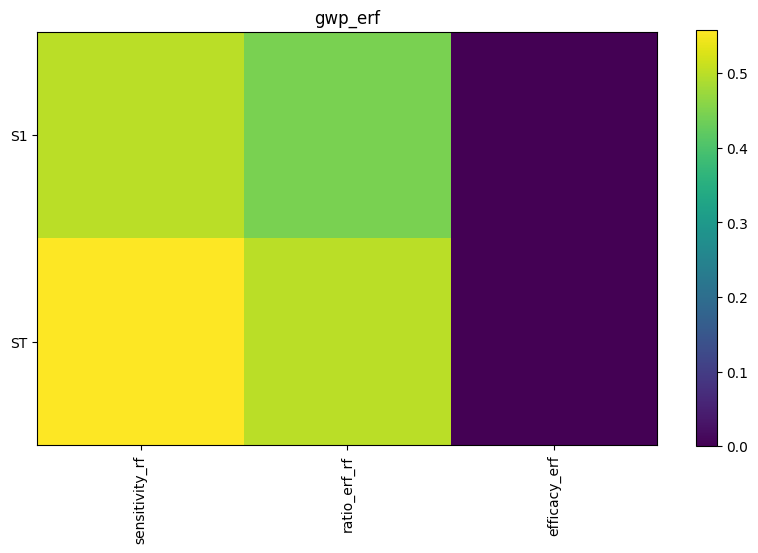

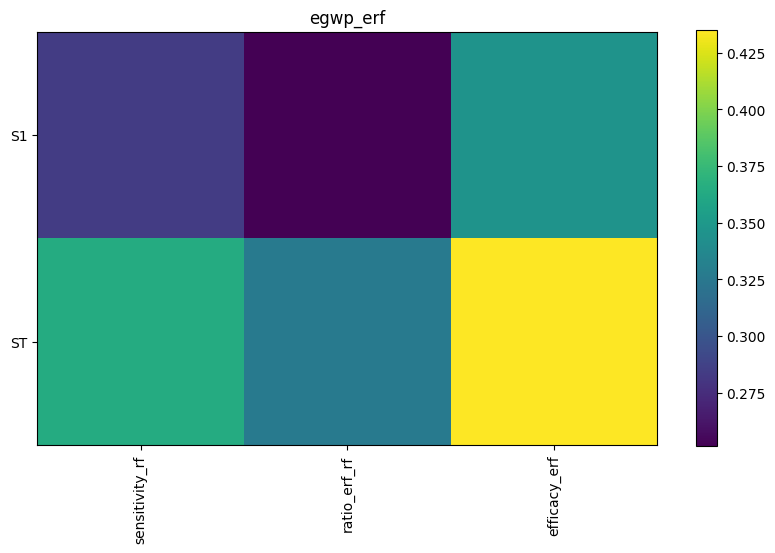

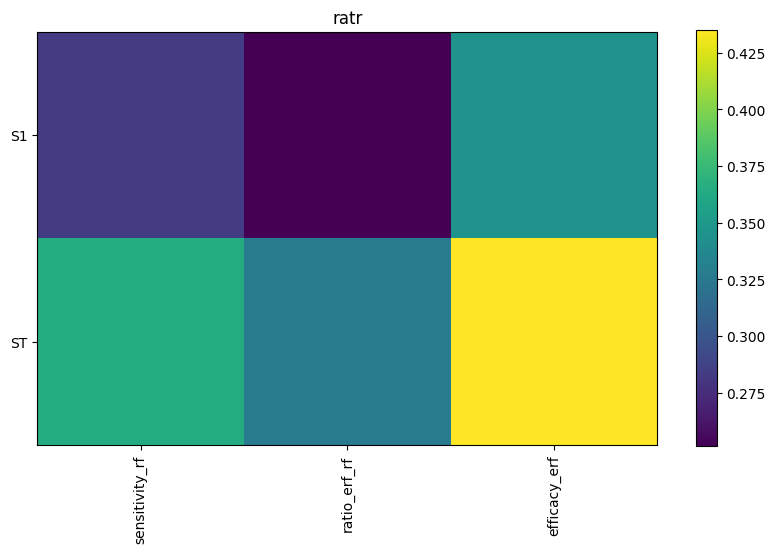

In [5]:
# Plot heatmaps
for output in sp["outputs"]:
    sp.heatmap(output)

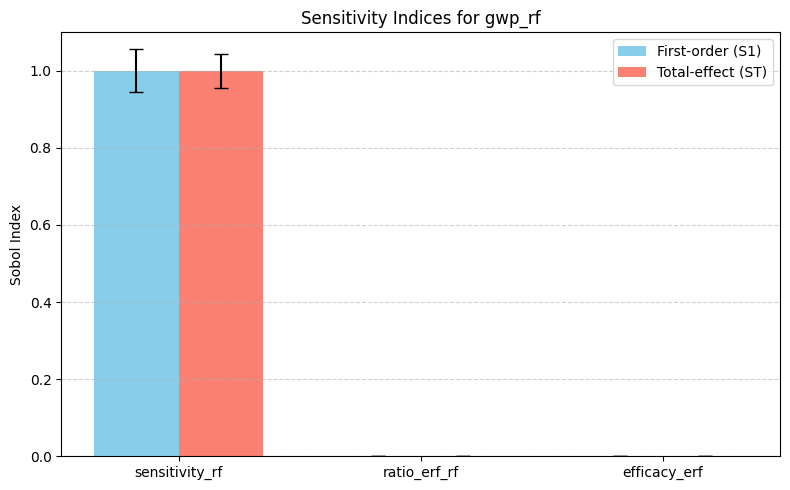

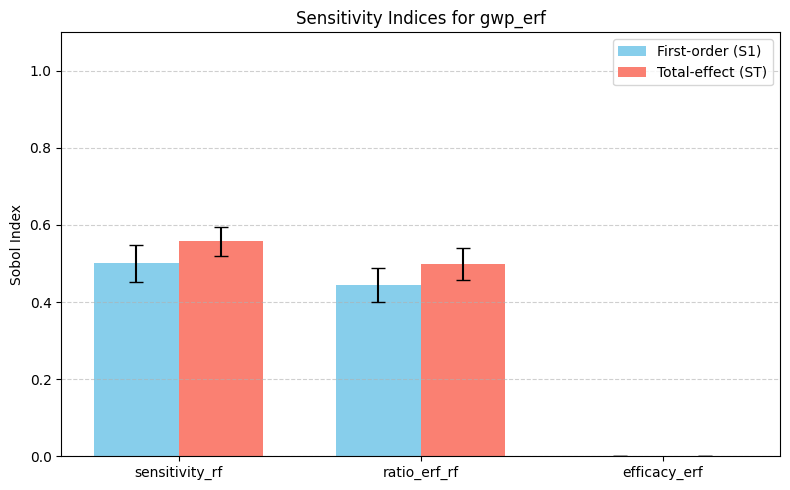

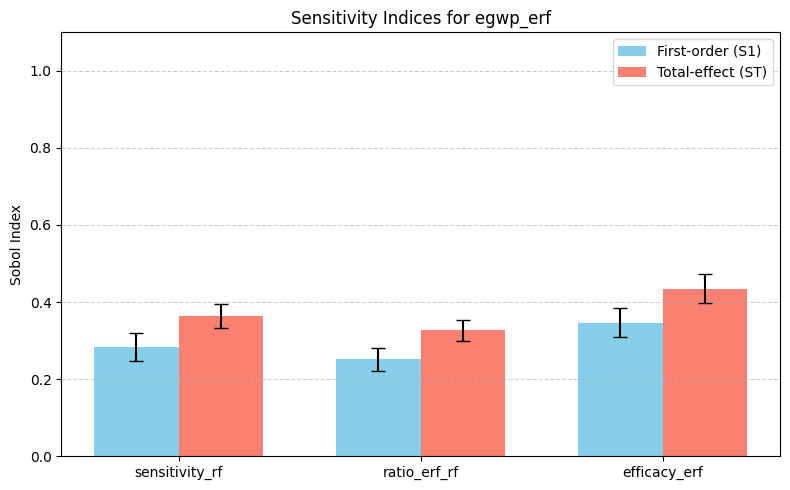

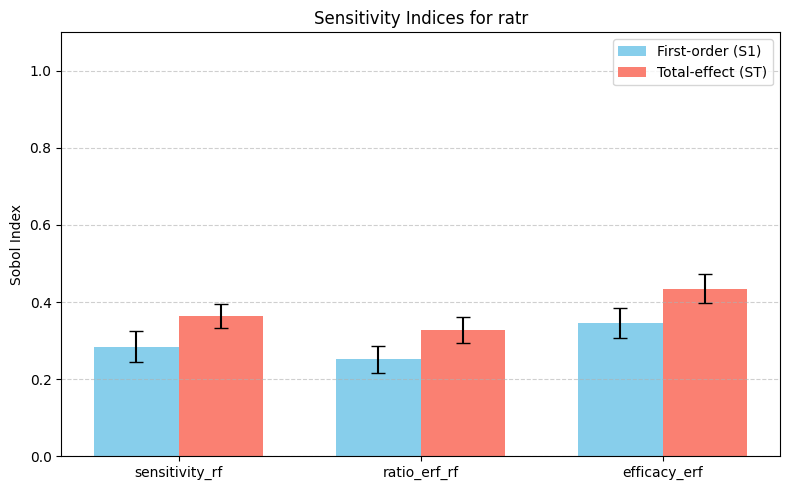

In [6]:
# Plot bars
names = sp["names"]
outputs = sp["outputs"]
analysis = sp.analysis

for i, output in enumerate(outputs):
    S1 = analysis[output]["S1"]
    S1_conf = analysis[output]["S1_conf"]
    ST = analysis[output]["ST"]
    ST_conf = analysis[output]["ST_conf"]

    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.bar(x - width/2, S1, width, yerr=S1_conf, capsize=5, label='First-order (S1)', color='skyblue')
    ax.bar(x + width/2, ST, width, yerr=ST_conf, capsize=5, label='Total-effect (ST)', color='salmon')

    ax.set_ylabel('Sobol Index')
    ax.set_title(f"Sensitivity Indices for {output}")
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim(0, 1.1)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [7]:
np.sum(ST)

np.float64(1.1255299815103423)

In [8]:
# Define problem
sp = ProblemSpec({
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        [2.23e-12, 7.96e-13],
        [0.23, 0.87],
        [0.12, 0.64]
    ],
    'dists': ['norm', 'unif', 'unif'],
    "outputs": ["gwp_rf", "gwp_erf", "egwp_erf", "ratr"],
})

# Sample with Morris
sp.sample_morris(N=50, num_levels=4)

# Define wrapped function
time_horizon = 100
def wrapped_func(X):
    return np.array([climate_metric_parametric(time_horizon, *row) for row in X])

# Evaluate model
sp.evaluate(wrapped_func)

# Analyze Morris
sp.analyze_morris(print_to_console=True)

                mu  mu_star  sigma  mu_star_conf
sensitivity_rf NaN      NaN    NaN           NaN
ratio_erf_rf   NaN      NaN    NaN           NaN
efficacy_erf   NaN      NaN    NaN           NaN
                mu  mu_star  sigma  mu_star_conf
sensitivity_rf NaN      NaN    NaN           NaN
ratio_erf_rf   NaN      NaN    NaN           NaN
efficacy_erf   NaN      NaN    NaN           NaN
                mu  mu_star  sigma  mu_star_conf
sensitivity_rf NaN      NaN    NaN           NaN
ratio_erf_rf   NaN      NaN    NaN           NaN
efficacy_erf   NaN      NaN    NaN           NaN
                mu  mu_star  sigma  mu_star_conf
sensitivity_rf NaN      NaN    NaN           NaN
ratio_erf_rf   NaN      NaN    NaN           NaN
efficacy_erf   NaN      NaN    NaN           NaN


C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\analyze\morris.py:453: RuntimeWarning: invalid value encountered in subtract
  delta_variables = np.subtract(input_matrix[:, 1:, :], input_matrix[:, 0:-1, :])
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\analyze\morris.py:453: RuntimeWarning: invalid value encountered in subtract
  delta_variables = np.subtract(input_matrix[:, 1:, :], input_matrix[:, 0:-1, :])
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\analyze\morris.py:453: RuntimeWarning: invalid value encountered in subtract
  delta_variables = np.subtract(input_matrix[:, 1:, :], input_matrix[:, 0:-1, :])
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\analyze\morris.py:453: RuntimeWarning: invalid value encountered in subtract
  delta_variables = np.subtract(input_matrix[:, 1:, :], input_matrix[:, 0:-1, :])


Samples:
	3 parameters: ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf']
	200 samples
Outputs:
	4 outputs: ['gwp_rf', 'gwp_erf', 'egwp_erf', 'ratr']
	200 evaluations
Analysis:
gwp_rf:
                mu  mu_star  sigma  mu_star_conf
sensitivity_rf NaN      NaN    NaN           NaN
ratio_erf_rf   NaN      NaN    NaN           NaN
efficacy_erf   NaN      NaN    NaN           NaN:
gwp_erf:
                mu  mu_star  sigma  mu_star_conf
sensitivity_rf NaN      NaN    NaN           NaN
ratio_erf_rf   NaN      NaN    NaN           NaN
efficacy_erf   NaN      NaN    NaN           NaN:
egwp_erf:
                mu  mu_star  sigma  mu_star_conf
sensitivity_rf NaN      NaN    NaN           NaN
ratio_erf_rf   NaN      NaN    NaN           NaN
efficacy_erf   NaN      NaN    NaN           NaN:
ratr:
                mu  mu_star  sigma  mu_star_conf
sensitivity_rf NaN      NaN    NaN           NaN
ratio_erf_rf   NaN      NaN    NaN           NaN
efficacy_erf   NaN      NaN    NaN           NaN:


In [9]:
# ---- Étape 1 : définition du problème (toutes bornes en [0,1] pour normalisation) ----
problem = {
    'num_vars': 3,
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        [0, 1],        # Uniforme → sera transformé en loi normale
        [0.23, 0.87],  # Uniforme (direct)
        [0.12, 0.64]   # Uniforme (direct)
    ]
}

# ---- Étape 2 : paramètres de la loi normale pour sensitivity_rf ----
mean_rf = 7.96e-13
std_rf = 7.96e-13

# ---- Étape 3 : échantillonnage Morris ----
param_values = morris_sampler.sample(problem, N=100, num_levels=4)

# ---- Étape 4 : transformation de sensitivity_rf (colonne 0) en loi normale ----
u = np.clip(param_values[:, 0], 1e-6, 1 - 1e-6)
param_values[:, 0] = norm.ppf(u, loc=mean_rf, scale=std_rf)

# ---- Étape 5 : fonction simulée (exemple) ----
def climate_metric_parametric(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf):
    gwp_rf = gwp_rf_function(time_horizon, sensitivity_rf)
    gwp_erf = gwp_erf_function(time_horizon, sensitivity_rf, ratio_erf_rf)
    egwp_erf = egwp_function(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf)
    ratr = ratr_function(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf)
    return gwp_rf, gwp_erf, egwp_erf, ratr

# ---- Étape 6 : exécution du modèle ----
time_horizon = 100
Y = np.array([climate_metric_parametric(time_horizon, *row) for row in param_values])

# ---- Étape 7 : analyse Morris ----
outputs = ["gwp_rf", "gwp_erf", "egwp_erf", "ratr"]
results = {}
for i, output_name in enumerate(outputs):
    Si = morris.analyze(problem, param_values, Y[:, i], print_to_console=False)
    results[output_name] = Si

# ---- Étape 8 : affichage exemple ----
print("Indices de Morris pour gwp_rf")
print("mu_star:", results['gwp_rf']['mu_star'])
print("sigma  :", results['gwp_rf']['sigma'])

Indices de Morris pour gwp_rf
mu_star: [70.5743461527329 0.0 0.0]
sigma  : [3.94608881e-11 0.00000000e+00 0.00000000e+00]


In [10]:
def plot_morris(results, output_name, param_names):
    mu_star = results[output_name]['mu_star']
    sigma = results[output_name]['sigma']

    plt.figure(figsize=(6, 5))
    plt.scatter(mu_star, sigma, s=80, edgecolors='k', alpha=0.8)

    for i, name in enumerate(param_names):
        plt.text(mu_star[i] + 0.01 * max(mu_star), sigma[i], name, fontsize=12)

    plt.xlabel(r'$\mu^*$ (Importance moyenne)', fontsize=12)
    plt.ylabel(r'$\sigma$ (Effets non-linéaires / interactions)', fontsize=12)
    plt.title(f"Morris - Sensibilité pour '{output_name}'", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

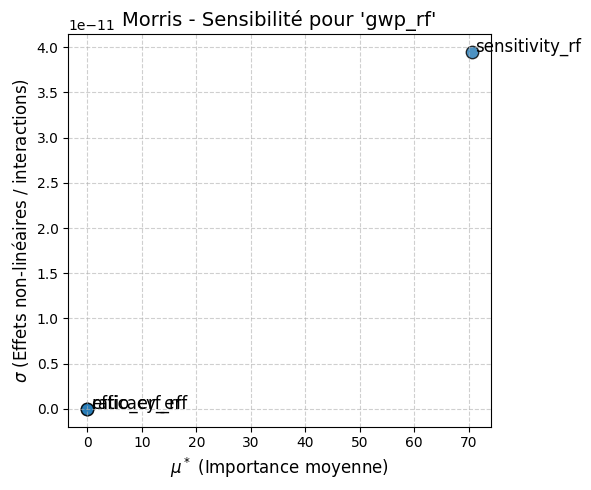

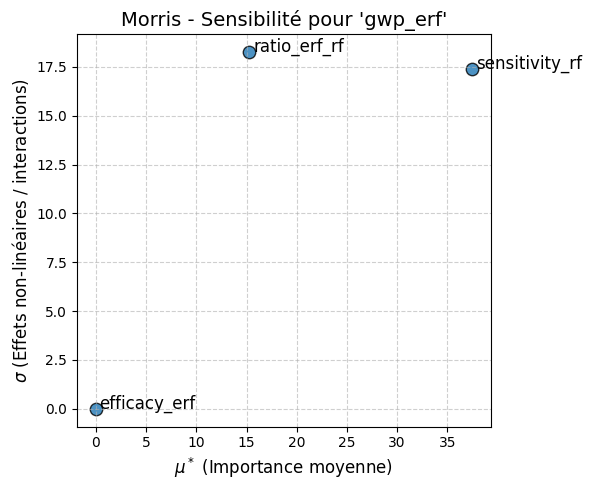

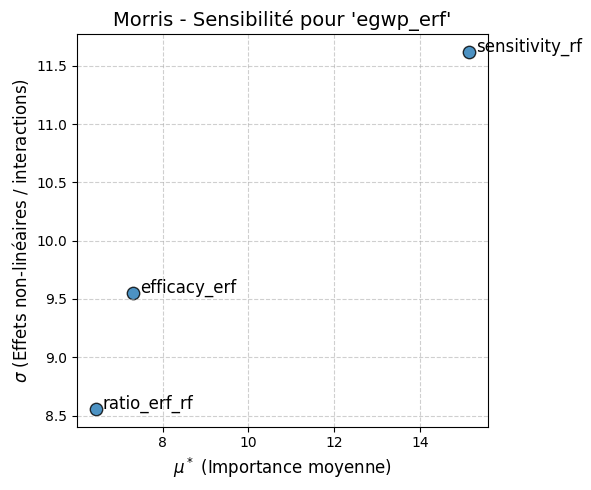

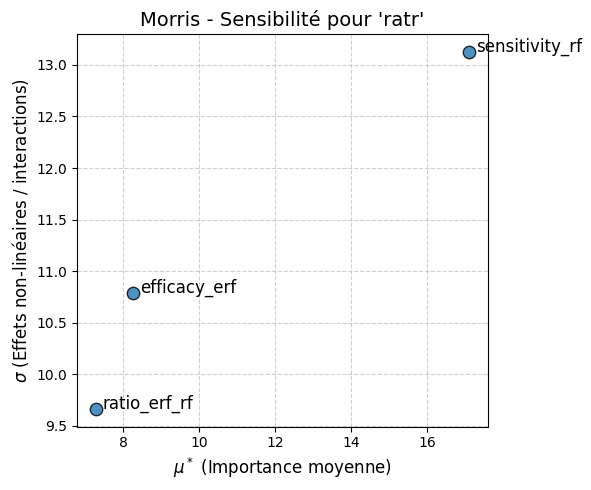

In [11]:
param_names = ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf']

for output_name in outputs:
    plot_morris(results, output_name, param_names)